In [7]:
import os
import sys
sys.path.append("../../../..")
from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics
from nebula.misc.plots import plot_roc_curves, plot_cv_metrics_dict
from nebula.models.attention import TransformerEncoderChunks
from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, *[".."]*4)
import numpy as np
from collections import defaultdict
from pandas import DataFrame, concat
FPRS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]

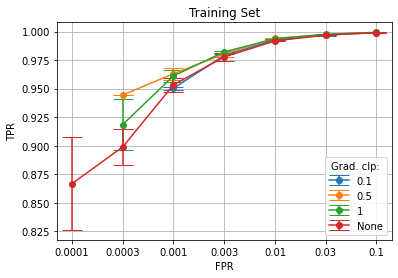

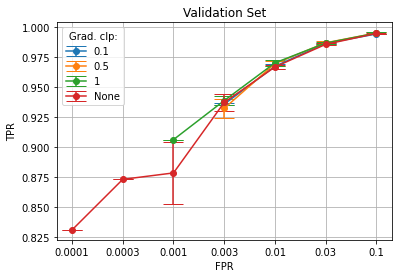

In [2]:
folder = "."
training_files = [x for x in os.listdir(folder) if x.endswith("training.json")]
validation_files = [x for x in os.listdir(folder) if x.endswith("validation.json")]

def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[2]

metrics_train = read_cv_metrics_folder('.', key_extractor, training_filter)
metrics_val = read_cv_metrics_folder('.', key_extractor, validation_filter)

TITLE = "Grad. clp:"
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [5]:
model_config = {
    "vocab_size": 50002,
    "maxlen": 512,
    "chunk_size": 64,
    "dModel": 64,
    "nHeads": 8,
    "dHidden": 256,
    "nLayers": 2,
    "numClasses": 1,
    "hiddenNeurons": [
        64
    ],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False
}

folder = os.path.join(SCRIPT_PATH, "..", "norm_first_limit_None_1677340681")
data_splits = read_cv_data_splits(folder)

roc_metrics_val = get_model_rocs(
    run_types=["None", "0.1", "0.5", "1"], 
    model_class=TransformerEncoderChunks,
    model_config=model_config,
    data_splits=data_splits,
)

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(roc_metrics_val)

Model files:
	None: ['.\\training_files\\1677328633-model.torch', '.\\training_files\\1677329045-model.torch', '.\\training_files\\1677329439-model.torch']
	0.1: ['.\\training_files\\1677329834-model.torch', '.\\training_files\\1677330238-model.torch', '.\\training_files\\1677330644-model.torch']
	0.5: ['.\\training_files\\1677331048-model.torch', '.\\training_files\\1677331453-model.torch', '.\\training_files\\1677331856-model.torch']
	1: ['.\\training_files\\1677332263-model.torch', '.\\training_files\\1677332668-model.torch', '.\\training_files\\1677333072-model.torch']

Evaluating None_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 26.06it/s]


Evaluating None_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:14<00:00, 26.71it/s]


Evaluating None_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 26.23it/s]


Evaluating 0.1_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:14<00:00, 26.56it/s]


Evaluating 0.1_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:14<00:00, 26.50it/s]


Evaluating 0.1_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 26.10it/s]


Evaluating 0.5_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 25.95it/s]


Evaluating 0.5_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 25.91it/s]


Evaluating 0.5_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 25.87it/s]


Evaluating 1_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 25.63it/s]


Evaluating 1_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 25.48it/s]


Evaluating 1_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:16<00:00, 24.38it/s]


,0.0001,0.0003,0.0010,0.0030,0.0100,0.0300,0.1000,0.3000
None,0.600178,0.733797,0.869407,0.936781,0.967251,0.985831,0.994733,0.998873
0.1,0.548439,0.701473,0.862182,0.927273,0.966785,0.987309,0.994597,0.998892
0.5,0.491964,0.694987,0.896447,0.933804,0.969466,0.986900,0.995005,0.998911
1,0.517743,0.696700,0.884596,0.932251,0.971488,0.987016,0.995277,0.998795


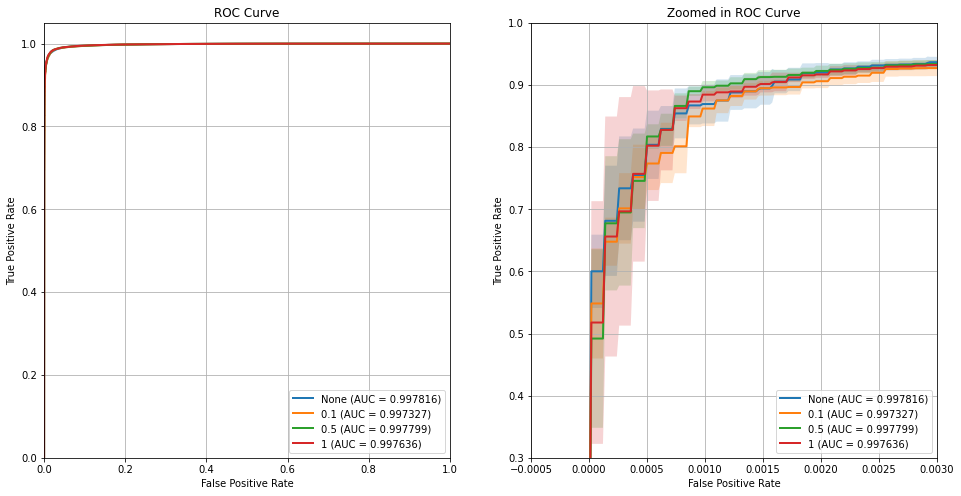

In [8]:
def report_metrics(base_fpr, tprs_mean, tprs_std, metrics, xlim=[-0.0005, 0.3], ylim=[0.6, 1]):
    tprsdf = DataFrame()
    for i, model_type in enumerate(tprs_mean.keys()):
        if i == 0:
            axs = None
        axs = plot_roc_curves(
            base_fpr, 
            tprs_mean[model_type], 
            tpr_std=tprs_std[model_type],
            model_name=f"{model_type}",
            axs=axs,
            roc_auc=metrics[model_type][0][2],
            xlim=xlim,
            ylim=ylim
        )
        tprs = defaultdict(list)
        for fpr in FPRS:
            tpr = tprs_mean[model_type][np.argmin(np.abs(base_fpr - fpr))]
            tprs[fpr].append(tpr)
        tprsdf = concat([tprsdf, DataFrame(tprs, index=[model_type])])
    [ax.grid() for ax in axs]
    _ = [ax.legend(loc='lower right') for ax in axs]
    return tprsdf

report_metrics(base_fpr_val, tprs_mean_val, tprs_std_val, roc_metrics_val, xlim=[-0.0005, 0.003], ylim=[0.3, 1.0])

## Test set ROCs

In [9]:
xtestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_vocab_size_50000_maxlen_512_x.npy")
X_test = np.load(xtestpath)
ytestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_y.npy")
y_test = np.load(ytestpath)

splits = 3
data_splits = [{"X_test": X_test, "y_test": y_test}]*splits

metrics = get_model_rocs(
    run_types=["None", "0.1", "0.5", "1"],
    model_class=TransformerEncoderChunks,
    model_config=model_config,
    data_splits=data_splits,
)

base_fpr, tprs_mean, tprs_std = allign_metrics(metrics)

Model files:
	None: ['.\\training_files\\1677328633-model.torch', '.\\training_files\\1677329045-model.torch', '.\\training_files\\1677329439-model.torch']
	0.1: ['.\\training_files\\1677329834-model.torch', '.\\training_files\\1677330238-model.torch', '.\\training_files\\1677330644-model.torch']
	0.5: ['.\\training_files\\1677331048-model.torch', '.\\training_files\\1677331453-model.torch', '.\\training_files\\1677331856-model.torch']
	1: ['.\\training_files\\1677332263-model.torch', '.\\training_files\\1677332668-model.torch', '.\\training_files\\1677333072-model.torch']

Evaluating None_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 27.15it/s]


Evaluating None_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 25.50it/s]


Evaluating None_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 26.71it/s]


Evaluating 0.1_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 25.90it/s]


Evaluating 0.1_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 26.45it/s]


Evaluating 0.1_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 26.07it/s]


Evaluating 0.5_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 26.23it/s]


Evaluating 0.5_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 25.28it/s]


Evaluating 0.5_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 26.17it/s]


Evaluating 1_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 26.07it/s]


Evaluating 1_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 25.81it/s]


Evaluating 1_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:10<00:00, 26.17it/s]


,0.0001,0.0003,0.0010,0.0030,0.0100,0.0300,0.1000,0.3000
None,0.232089,0.348399,0.509802,0.646531,0.744301,0.835265,0.895104,0.960296
0.1,0.166046,0.327910,0.522103,0.626077,0.720657,0.807437,0.894892,0.961785
0.5,0.190577,0.320571,0.585132,0.683115,0.764685,0.842887,0.900174,0.948988
1,0.233613,0.385444,0.574108,0.666631,0.755894,0.840662,0.899996,0.962671


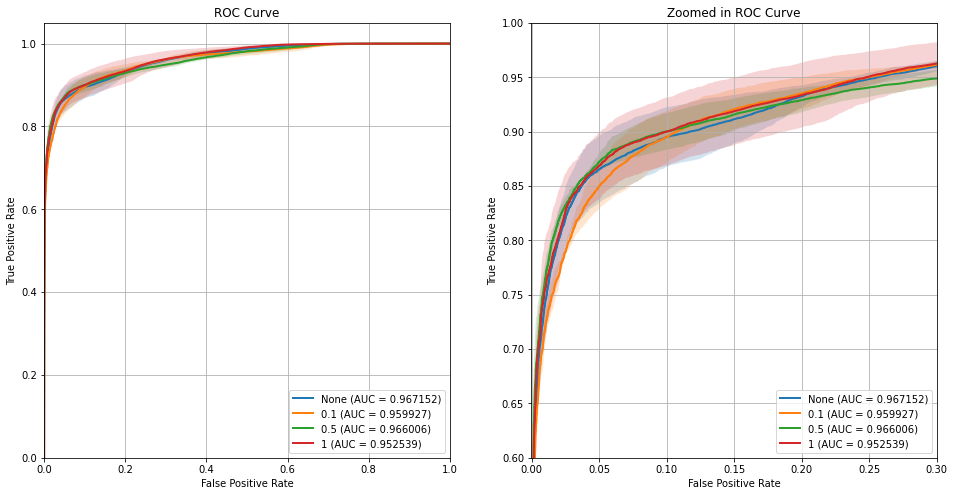

In [10]:
report_metrics(base_fpr, tprs_mean, tprs_std, metrics)